# KNN

This notebook aims to use a pre-trained network in order to train a KNN-algorithm to make the final predictions.

In [3]:
#Uncomment the line bellow only if it is necesssary
!unzip drive/MyDrive/hackathon-isae-2021-patch-retrieval.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Train/Train/time_series_4939_1.png  
  inflating: Train/Train/time_series_4939_2.png  
  inflating: Train/Train/time_series_4939_3.png  
  inflating: Train/Train/time_series_4939_4.png  
  inflating: Train/Train/time_series_4939_5.png  
  inflating: Train/Train/time_series_4939_6.png  
  inflating: Train/Train/time_series_4939_7.png  
  inflating: Train/Train/time_series_493_0.png  
  inflating: Train/Train/time_series_493_1.png  
  inflating: Train/Train/time_series_493_2.png  
  inflating: Train/Train/time_series_493_3.png  
  inflating: Train/Train/time_series_493_4.png  
  inflating: Train/Train/time_series_493_5.png  
  inflating: Train/Train/time_series_493_6.png  
  inflating: Train/Train/time_series_493_7.png  
  inflating: Train/Train/time_series_4940_0.png  
  inflating: Train/Train/time_series_4940_1.png  
  inflating: Train/Train/time_series_4940_2.png  
  inflating: Train/Train/time_

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import rotate
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from glob import glob
from typing import List,Optional,Callable
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import sys
import matplotlib.pyplot as plt

## Preparation
### Model loader

In [8]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class MetricResnet(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(512 * 7 * 7, 128)
        self.activation = nn.ReLU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.activation(x)
        x = self.linear_1(x)
        x = F.normalize(x, p=2, dim=1)
        return x
  

In [10]:
def model_inference(model:nn.Module, loader, device='cuda',rot=False):
    model.eval()
    list_pred = []
    list_path_name = []
    with torch.no_grad():
        for image,path in tqdm_notebook(loader):
            if rot == True:
                a = np.random.choice([90,180,-90],size=1)
                image = rotate(image,angle=int(a))
            image = image.to(device)
            pred = model(image)
            pred = pred.view(-1) # BATCH SIZE EQUAL TO 1
            list_pred.append(pred.detach().cpu().numpy())
            list_path_name.append(path)
    return list_pred,list_path_name

In [11]:
path_model = "/content/inception_1ep_margin2_lr-4_batch32_workers8.pt"
embedding_model = torch.load(path_model)#,map_location=torch.device('cpu'))

### Data loader

In [12]:
class ImageDataset(Dataset):
    def __init__(self, list_path: List[int], transform: Optional[Callable]=None):
        self.list_path = list_path
        if transform is None:
            self.transform = transforms.ToTensor()
        else:
            self.transform = transform

        self.inception_transform=transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self) -> int:
        return len(self.list_path)
    def __getitem__(self, index:int):

        path = self.list_path[index]
        image = Image.open(path)
        image = self.transform(image)
        image = self.inception_transform(image)
        final_path = path.split("/")[-1]
        return image,final_path

In [13]:
#Always run this cell
path_train = sorted(glob("Train/Train/*.png"))
images_train = ImageDataset(path_train)
loader_train = DataLoader(images_train,batch_size=1,num_workers = 2)
list_pred_train, list_path_train = model_inference(embedding_model,loader_train)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


(optional) Run only **1 cell** if you want to aply contrast



In [14]:
#Run this cell if you want apply constrast transformation
contrast_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(contrast=1),
])
transform = contrast_transform

images_train_trans = ImageDataset(path_train,transform=transform)
loader_train_trans = DataLoader(images_train_trans,batch_size=1,num_workers = 2)
list_pred_train_trans, list_path_train_trans = model_inference(embedding_model,loader_train_trans)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


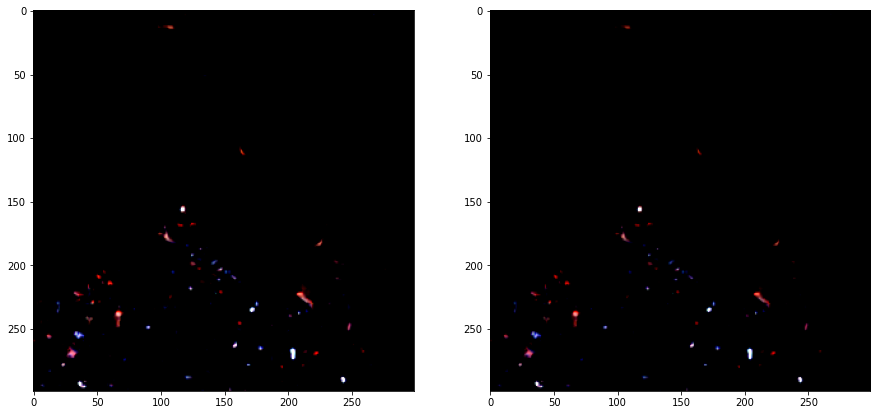

In [15]:
#Run this cell if and only if you have run the cell above
fig,ax = plt.subplots(1,2,figsize=(15,9))
ax[0].imshow(images_train_trans[0][0].permute(1,2,0).numpy())
ax[1].imshow(images_train[0][0].permute(1,2,0).numpy())

(optional) Run the cell below if you want to apply rotation


In [ ]:
#Run this cell if you want apply rotation transformation
list_pred_train_rot, list_path_train_rot = model_inference(embedding_model,loader_train,rot=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: ignored

Run only **ONE** of the cell below depending on your case :

In [ ]:
path_test = sorted(glob("Test/Test/*.png"))
images_test = ImageDataset(path_test)
loader_test = DataLoader(images_test,batch_size=1,num_workers = 2)
list_pred_test, list_path_test = model_inference(embedding_model,loader_test)

In [ ]:

path_test = sorted(glob("Test/Test/*.png"))
images_test = ImageDataset(path_test,transform=contrast_transform)
loader_test = DataLoader(images_test,batch_size=1,num_workers = 2)
list_pred_test, list_path_test = model_inference(embedding_model,loader_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## KNN training

In [ ]:
len(list_pred_train + list_pred_train_trans)

NameError: ignored

Run only **1 cell** according to your situation




In [ ]:
#1
list_label_train = [int(path.split("_")[-2]) for path in [p[0] for p in list_path_train]]
X_train = np.stack(list_pred_train, axis=0)
y_train = np.array(list_label_train)

In [ ]:
#2
list_label_train = [int(path.split("_")[-2]) for path in [p[0] for p in list_path_train]]
list_label_train_trans = [int(path.split("_")[-2]) for path in [p[0] for p in list_path_train_trans]]
X_train = np.stack(list_pred_train+list_pred_train_trans, axis=0)
y_train = np.array(list_label_train+list_label_train_trans)

NameError: ignored

In [ ]:
#3
list_label_train = [int(path.split("_")[-2]) for path in [p[0] for p in list_path_train]]
list_label_train_trans = [int(path.split("_")[-2]) for path in [p[0] for p in list_path_train_trans]]
list_label_train_rot = [int(path.split("_")[-2]) for path in [p[0] for p in list_path_train_rot]]
X_train = np.stack(list_pred_train+list_pred_train_trans+list_pred_train_rot, axis=0)
y_train = np.array(list_label_train+list_label_train_trans+list_label_train_rot)

Run only **1 cell** according to the model you have chosen

In [ ]:
#KNN model
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=500))
pipe.fit(X_train, y_train)

In [ ]:
#Bayesian model
pipe = make_pipeline(StandardScaler(), GaussianNB())
pipe.fit(X_train, y_train)

In [ ]:
#Choose the cell above or this one. The cell above looks better
#knn_model = KNeighborsClassifier(n_neighbors=500)
#knn_model.fit(X_train, y_train)

## Predictions

In [ ]:
X_test = np.stack(list_pred_test, axis=0)
pred_knn_proba = pipe.predict_proba(X_test)    

In [ ]:
top_k = np.argsort(pred_knn_proba.copy(), axis=1)[:, -20:]
np.save("top_k.npy",top_k)

## Submission file

In [ ]:
def submission(top_k,list_path_test):
    import csv
    with open('submission.csv', mode='w') as csv_file:
        fieldnames = ['file_name', 'label']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for (i,pred),path in zip(enumerate(top_k),list_path_test):
            best_labels = " ".join([str(a) for a in top_k[i][::-1]])
            writer.writerow({'file_name': path[0], 'label':best_labels})

submission(top_k,list_path_test)

## Visualization

In [ ]:
nb = 5
nb_pred = 10
fig,ax = plt.subplots(nb_pred,nb+1,figsize=(18,35))
for i in range(nb_pred):
    image_test_i = images_test[i][0].permute(1,2,0).numpy()
    first_n_pred = top_k[i][-nb:][::-1]
    ax[i,0].imshow(image_test_i)
    ax[i,0].set_title("Test image n°{}".format(i))
    for j,n in enumerate(first_n_pred):
        a = np.where(list_label_train==n)[0][0]
        image_pred_i = images_train[a][0].permute(1,2,0).numpy()
        ax[i,j+1].imshow(image_pred_i)
        ax[i,j+1].set_title("Prediction n°{}, Time serie n° {}".format(j,n))